# Assessment: Weekly deliverable template - Classification
<font color='#AC135A'>**Applied Machine Learning** - **Sheffield Hallam University**</font>


---

## Introduction
Add your solutions to the different sub-tasks requested for this deliverable.

<font color='red'>DO NOT ADD MORE CELLS TO THE FINAL VERSION OF THIS NOTEBOOK.

### 1. Dataset loading

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns    
import pandas as pd
from sklearn.model_selection import KFold
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression  
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score    
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import fcluster, linkage
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering 


In [2]:
# Loading and pre-processing the data as in the week 3 assessment

df = pd.read_csv('wines_SPA.csv')

df = df.drop_duplicates()

# Removing columns I do not want to further use.
df = df.drop(columns=['country', 'acidity'], axis=1)

# Drop missing values and drop duplicates again
df = df.dropna()

# Engineering features

# Price
df['price_log'] = np.log(df['price'])

# Year
# First, convert year into a numeric column, all strings will be NaN
df['year_numeric'] = pd.to_numeric(df['year'], errors='coerce') 
# Add a column to indicate missing values
df['is_nv'] = (df['year_numeric'].isna()).astype(int) 
# Get the median year for imputing
median_year = df['year_numeric'].median()
# impute
df['year_numeric'] = df['year_numeric'].fillna(median_year)
# calculate age
df['age'] = df['year_numeric'].max() + 1 - df['year_numeric']
# calculate log of age
df['age_log'] = np.log(df['age'])


# For categorical variables, only keep those with at least 175 occurrences (10% of all examples), others as 'Other'

# find unique values and their counts in categorical columns 
type_counts = df['type'].value_counts()
winery_counts = df['winery'].value_counts()
wine_counts = df['wine'].value_counts()
region_counts = df['region'].value_counts()

# from each remove the ones with less than 175 occurrences
type_to_keep = type_counts[type_counts >= 175].index
winery_to_keep = winery_counts[winery_counts >= 175].index
wine_to_keep = wine_counts[wine_counts >= 175].index
region_to_keep = region_counts[region_counts >= 175].index

# Create a new type column with only the frequent types, others as 'Other'
df['type_r'] = df['type'].where(df['type'].isin(type_to_keep), 'Other')
df['winery_r'] = df['winery'].where(df['winery'].isin(winery_to_keep), 'Other')
df['wine_r'] = df['wine'].where(df['wine'].isin(wine_to_keep), 'Other')
df['region_r'] = df['region'].where(df['region'].isin(region_to_keep), 'Other')           

# One-hot encode categorical variables leaving out the first category to avoid multicollinearity
type_dummies = pd.get_dummies(df['type_r'], prefix='type', drop_first=True)
winery_dummies = pd.get_dummies(df['winery_r'], prefix='winery', drop_first=True)
wine_dummies = pd.get_dummies(df['wine_r'], prefix='wine', drop_first=True)
region_dummies = pd.get_dummies(df['region_r'], prefix='region', drop_first=True)
# Concatenate the new dummy columns to the original dataframe
df = pd.concat([df, type_dummies, winery_dummies, wine_dummies, region_dummies], axis=1)
# save the dummy column names
type_columns = type_dummies.columns.tolist()    
winery_columns = winery_dummies.columns.tolist()
wine_columns = wine_dummies.columns.tolist()
region_columns = region_dummies.columns.tolist()




**Observations:**  

I only drop 'country' and 'acidity' this time, as they do not have any informational content. I keep add num_reviews, because maybe it is interesting for descriptive clustering. (As discussed in the last assessment, it is not suitable for predicting.) 

Also, I do include 'wine', 'winery' and 'region' this time as it maybe be interesting for clustering. However, I only keeo the values that occur at least in 10% of all examples (175 or more), while summarising the others as 'Others' as I assume that those features wouldn't be stable. (I don't know if the 10% is a good value, but it seems if there are not enough examples, the training is probably not very meaningful. So these 10% are an arbitrary value. I am curious to know if there is a way to determine what a good value would be.) 

### 1a. Feature set selection

In [ ]:
# I am now determining which features are actually the most relevant for determining the quality of a wine
# using Sequential Forward Selection (SFS) with a linear regression model and 5-fold cross-validation
# I will use Mean Absolute Error (MAE) and R2 as the performance metric.    
# Raschka et al. (2022). Machine Learning with Python and Scikit-Learn. Packt Publishing. p. 128ff.
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Define the feature set and target variable
feature_columns = ['price_log', 'age_log', 'is_nv', 'body'] + type_columns + winery_columns + wine_columns + region_columns
X = df[feature_columns]
y = df['rating']
# Initialize the linear regression model
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(StandardScaler(), LinearRegression())

# MAE
# Initialize the Sequential Forward Selector
sfs = SFS(pipe, 
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring='neg_mean_absolute_error', 
          cv=5, 
          n_jobs=-1)
# Perform SFS
sfs = sfs.fit(X, y)
# Get the selected features
selected_features = list(sfs.k_feature_names_)
print("Selected features (MAE):", selected_features)
# Get the performance of the selected feature set
print("CV MAE of selected features:", -sfs.k_score_)    

# R2
# Initialize the Sequential Forward Selector
sfs = SFS(pipe, 
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring='r2', 
          cv=5, 
          n_jobs=-1)
# Perform SFS
sfs = sfs.fit(X, y)
# Get the selected features
selected_features = list(sfs.k_feature_names_)
print("Selected features (R2):", selected_features)
# Get the performance of the selected feature set
print("CV R2 of selected features:", -sfs.k_score_)    




Selected features (MAE): ['price_log', 'age_log', 'is_nv', 'region_Priorato', 'region_Ribera del Duero', 'region_Rioja']
CV MAE of selected features: 0.11362899125990907
Selected features (R2): ['price_log', 'age_log', 'is_nv', 'type_Priorat Red', 'region_Priorato', 'region_Ribera del Duero', 'region_Rioja']
CV R2 of selected features: 80.66662996453142



**Observation:**

When I compare these results with the results from week 3 assessment, I see that "the best" MAE is actually higher at 0.11 compared with 0.084 with the features ['price_log', 'age_log', 'is_nv', 'body'] + type_columns. However, I did not do CV back then, so maybe that result was accidental. 

The R2 on the other hand is much better compared to week 3, when it was only around 50%. with the feature set ['price_log', 'age_log', 'is_nv', 'type_Priorat Red', 'region_Priorato', 'region_Ribera del Duero', 'region_Rioja'] 81% of the rating variance can be explained. 

I am only doing this exercise to decide on a number of feature combinations for the clustering (rather than being arbitrary or try literally every combination). As I want to see if unsupervised training gives me classes that correlate to rating in any way, I use rating as 


In [37]:
# I will now create some exemplatory feature sets based on these results which I will use for clustering:
# all features
feature_columns_all = ['price_log', 'age_log', 'is_nv','body'] + type_columns + winery_columns + wine_columns + region_columns
# selected features from SFS (MAE)
feature_columns_sfs_mae = ['price_log', 'age_log', 'is_nv', 'region_Priorato', 'region_Ribera del Duero', 'region_Rioja']
# selected features from SFS (R2)
feature_columns_sfs_r2 = ['price_log', 'age_log', 'is_nv', 'type_Priorat Red', 'region_Priorato', 'region_Ribera del Duero', 'region_Rioja']
# Minimal feature set (based on the analysis in the previous assessment
feature_columns_minimal = ['price_log', 'age_log']

I also want to understand which features I need to use to get the best seperated clustering given a target number of clusters. I will try all combinations, just out of curiosity. 
Executing this takes some time!

In [ ]:
from itertools import combinations
X = df[feature_columns_all].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

feature_indices = range(X.shape[1])
cluster_range = range(2, 11)

for k in cluster_range:
    best_score = -1
    best_k = None
    best_features = None
    for r in range(1, len(feature_indices) + 1):
        for subset in combinations(feature_indices, r):
            X_subset = X_scaled[:, subset]
        
            model = KMeans(n_clusters=k, random_state=42)
            X_unique = np.unique(X_subset, axis=0)
            # Then check if you have enough unique points for k clusters
            if len(X_unique) < k:
                # Not enough unique points to form k clusters, skip this k
                continue
            labels = model.fit_predict(X_unique)
            n_labels = len(np.unique(labels))
            if len(X_unique) < 2 or n_labels >= len(X_unique):
                # Not enough samples to compute silhouette
                continue
            score = silhouette_score(X_unique, labels)
            if score > best_score:
                best_score = score
                best_k = k
                best_features = subset

   
    print(f"\nNumber of clusters: {best_k}")
    print(f"Best silhouette score: {best_score}")
    features = [feature_columns_all[i] for i in best_features]
    print(f"Best feature subset: {features}")


Number of clusters: 2
Best silhouette score: 0.7911081092926001
Best feature subset: ['price_log', 'is_nv']

Number of clusters: 3
Best silhouette score: 0.7429923548904095
Best feature subset: ['price_log', 'is_nv', 'type_Priorat Red', 'region_Priorato']

Number of clusters: 4
Best silhouette score: 0.6864401178150341
Best feature subset: ['price_log', 'type_Priorat Red', 'type_Red', 'type_Ribera Del Duero Red', 'region_Priorato', 'region_Ribera del Duero']

Number of clusters: 5
Best silhouette score: 0.6846281302206111
Best feature subset: ['price_log', 'type_Priorat Red', 'type_Red', 'type_Ribera Del Duero Red', 'region_Priorato', 'region_Ribera del Duero']

Number of clusters: 6
Best silhouette score: 0.6904640258740303
Best feature subset: ['price_log', 'is_nv', 'type_Priorat Red', 'type_Red', 'type_Ribera Del Duero Red', 'region_Priorato', 'region_Ribera del Duero']

Number of clusters: 7
Best silhouette score: 0.6652591752467313
Best feature subset: ['price_log', 'is_nv', 'typ

**Observation**

What is immediately interesting is that none of the feature sets that give the cleanest clusterings include "age_log".

However, I wonder how meaningful it is to select features simply based on best cluster separatability. I would expect that clustering by boolean features is generally better (because there are only two values). I guess one continuous feature may be ok to separate (as in price_log), but not multiple, as then the picture may become too complex. 

In [32]:

feature_columns_optimal_6_7_clusters = ['price_log', 'is_nv', 'type_Priorat Red', 'type_Red', 'type_Ribera Del Duero Red', 'region_Priorato', 'region_Ribera del Duero']


### 2. Clustering with results for different values of the parameters (model selection)



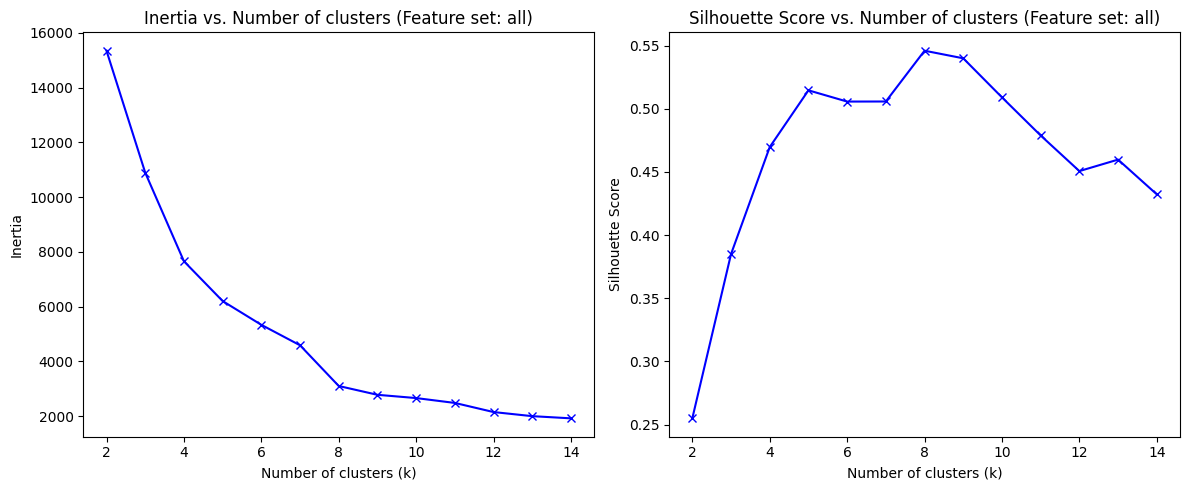

Scores for feature set: all
     k       Inertia  Silhouette Score
0    2  15351.808019          0.254993
1    3  10896.383030          0.384925
2    4   7657.025983          0.469657
3    5   6202.930102          0.514572
4    6   5333.375761          0.505674
5    7   4585.389356          0.505737
6    8   3097.569044          0.545923
7    9   2775.534708          0.539916
8   10   2656.292768          0.509018
9   11   2478.379679          0.478844
10  12   2145.119309          0.450662
11  13   1995.083884          0.459754
12  14   1915.389169          0.432256


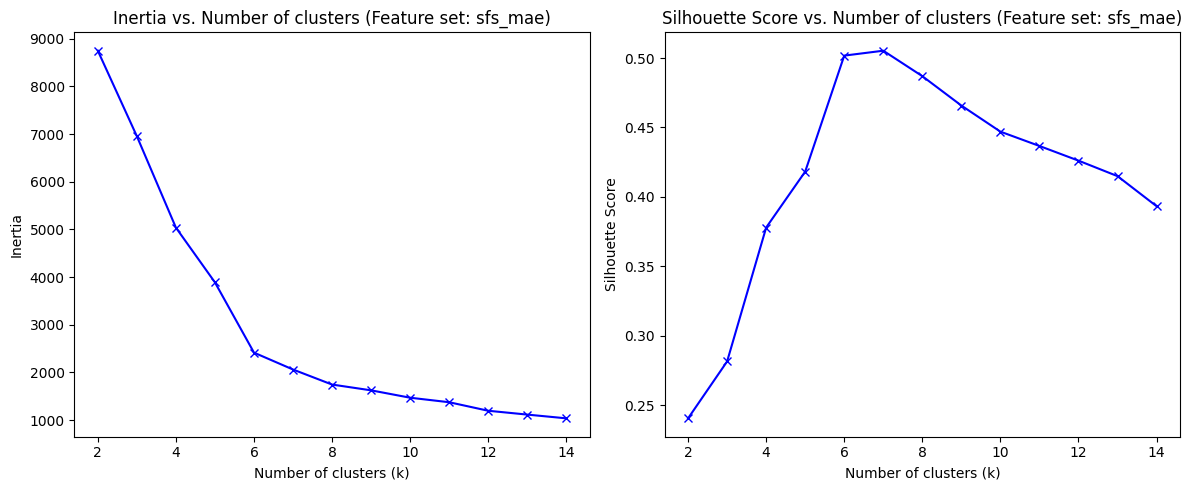

Scores for feature set: sfs_mae
     k      Inertia  Silhouette Score
0    2  8747.970245          0.240502
1    3  6954.550712          0.281492
2    4  5037.667183          0.377922
3    5  3888.956208          0.418222
4    6  2415.875257          0.501749
5    7  2061.603773          0.505278
6    8  1746.337728          0.486941
7    9  1625.112147          0.465782
8   10  1470.365621          0.446992
9   11  1375.672695          0.436659
10  12  1196.934778          0.426104
11  13  1116.461031          0.414935
12  14  1037.898688          0.393282


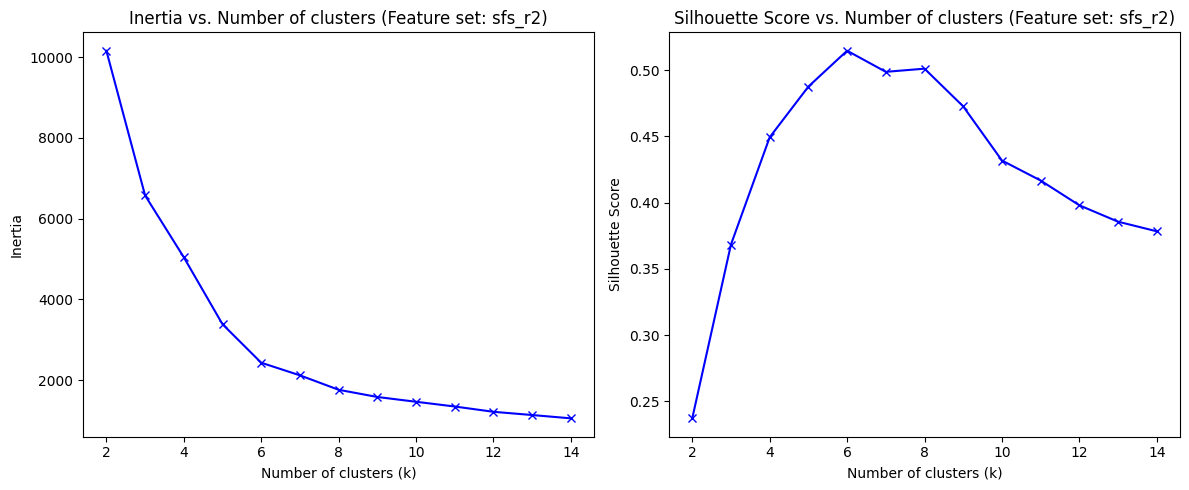

Scores for feature set: sfs_r2
     k       Inertia  Silhouette Score
0    2  10159.187493          0.237272
1    3   6575.711874          0.368398
2    4   5045.456571          0.449285
3    5   3386.652231          0.487531
4    6   2433.851812          0.514600
5    7   2121.722234          0.498667
6    8   1763.960236          0.501055
7    9   1585.569303          0.472585
8   10   1467.130971          0.431777
9   11   1349.753995          0.416667
10  12   1218.786882          0.397982
11  13   1138.670405          0.385621
12  14   1056.887911          0.378369


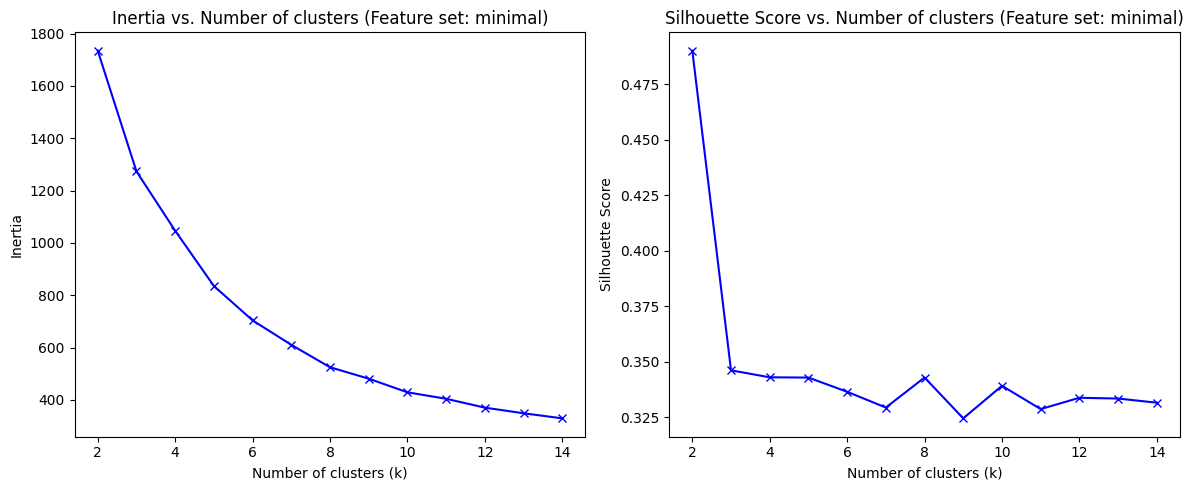

Scores for feature set: minimal
     k      Inertia  Silhouette Score
0    2  1734.833794          0.490219
1    3  1273.506368          0.346153
2    4  1046.682577          0.343004
3    5   835.411652          0.342876
4    6   704.011141          0.336480
5    7   610.497651          0.329367
6    8   524.851139          0.342900
7    9   481.098948          0.324502
8   10   428.990975          0.339168
9   11   404.274758          0.328676
10  12   370.410753          0.333769
11  13   348.880697          0.333426
12  14   329.470021          0.331556


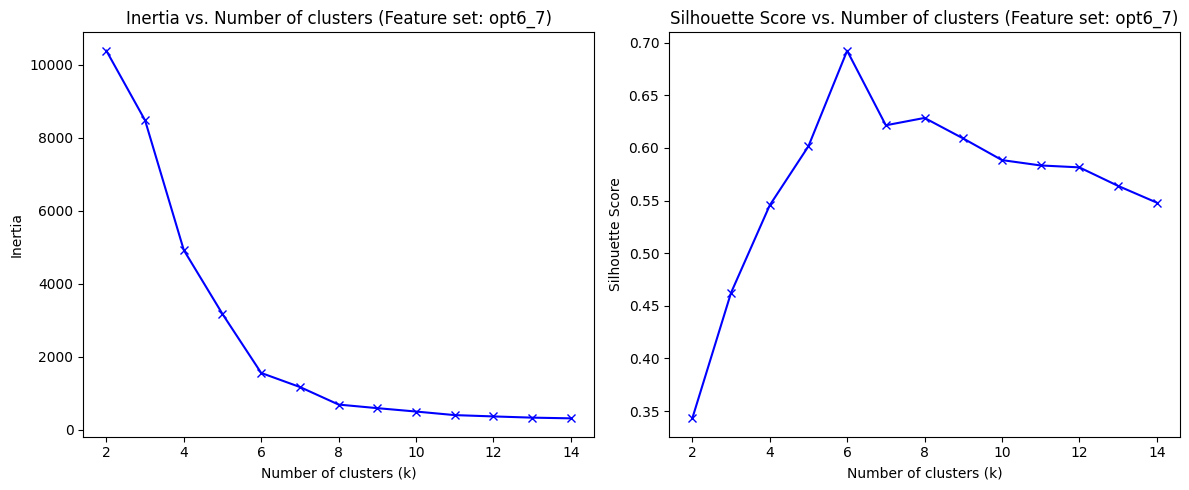

Scores for feature set: opt6_7
     k       Inertia  Silhouette Score
0    2  10380.751723          0.343141
1    3   8473.032966          0.462343
2    4   4921.624205          0.545500
3    5   3170.440594          0.601606
4    6   1555.597832          0.692354
5    7   1171.149495          0.621518
6    8    689.932112          0.628507
7    9    591.926130          0.608987
8   10    499.171694          0.588453
9   11    401.559332          0.583359
10  12    365.445642          0.581547
11  13    332.170978          0.563945
12  14    312.976423          0.548053


In [ ]:
# I now want to create inertia and silhouette plots for KMeans clustering with selected feature sets to determine the optimal number of clusters.
# Also include a table with the inertia and silhouette scores for each k.
# Define feature columns
feature_columns = {
    'all': feature_columns_all,
    'sfs_mae': feature_columns_sfs_mae,
    'sfs_r2': feature_columns_sfs_r2,
    'minimal': feature_columns_minimal,
    'opt6_7': feature_columns_optimal_6_7_clusters
}
for key, cols in feature_columns.items():
    X = df[cols]
    # Scaling the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    inertia = []
    silhouette = []
    K = range(2, 15)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)
        silhouette.append(silhouette_score(X_scaled, kmeans.labels_))
    
    # Plotting the inertia and silhouette scores
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title(f'Inertia vs. Number of clusters (Feature set: {key})')
    
    plt.subplot(1, 2, 2)
    plt.plot(K, silhouette, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score vs. Number of clusters (Feature set: {key})')
    
    plt.tight_layout()
    plt.show()
    # Displaying the inertia and silhouette scores in a table
    scores_df = pd.DataFrame({'k': K, 'Inertia': inertia, 'Silhouette Score': silhouette})
    print(f'Scores for feature set: {key}')
    print(scores_df)

**Observation:**

The plots show that the inertia elbows and the silhouette score peaks are nicely aligned for the different sets of features. 

The minimal feature set shows very poor clustering based on the silhouette score, and I will no longer proceed with it. 

All features (i.e. 11 features) has the best silhouette score at 8 clusters, peaking at close to 0.55.

Both R2 and MAE based features sets (7 and 6 featurers, resp.) have similar results, suggesting 6 and 7 clusters with silhouette scores just above 0.50.

The optimised feature set shows the expected very high peak at 6 clusters. 

## 2a Visualisations

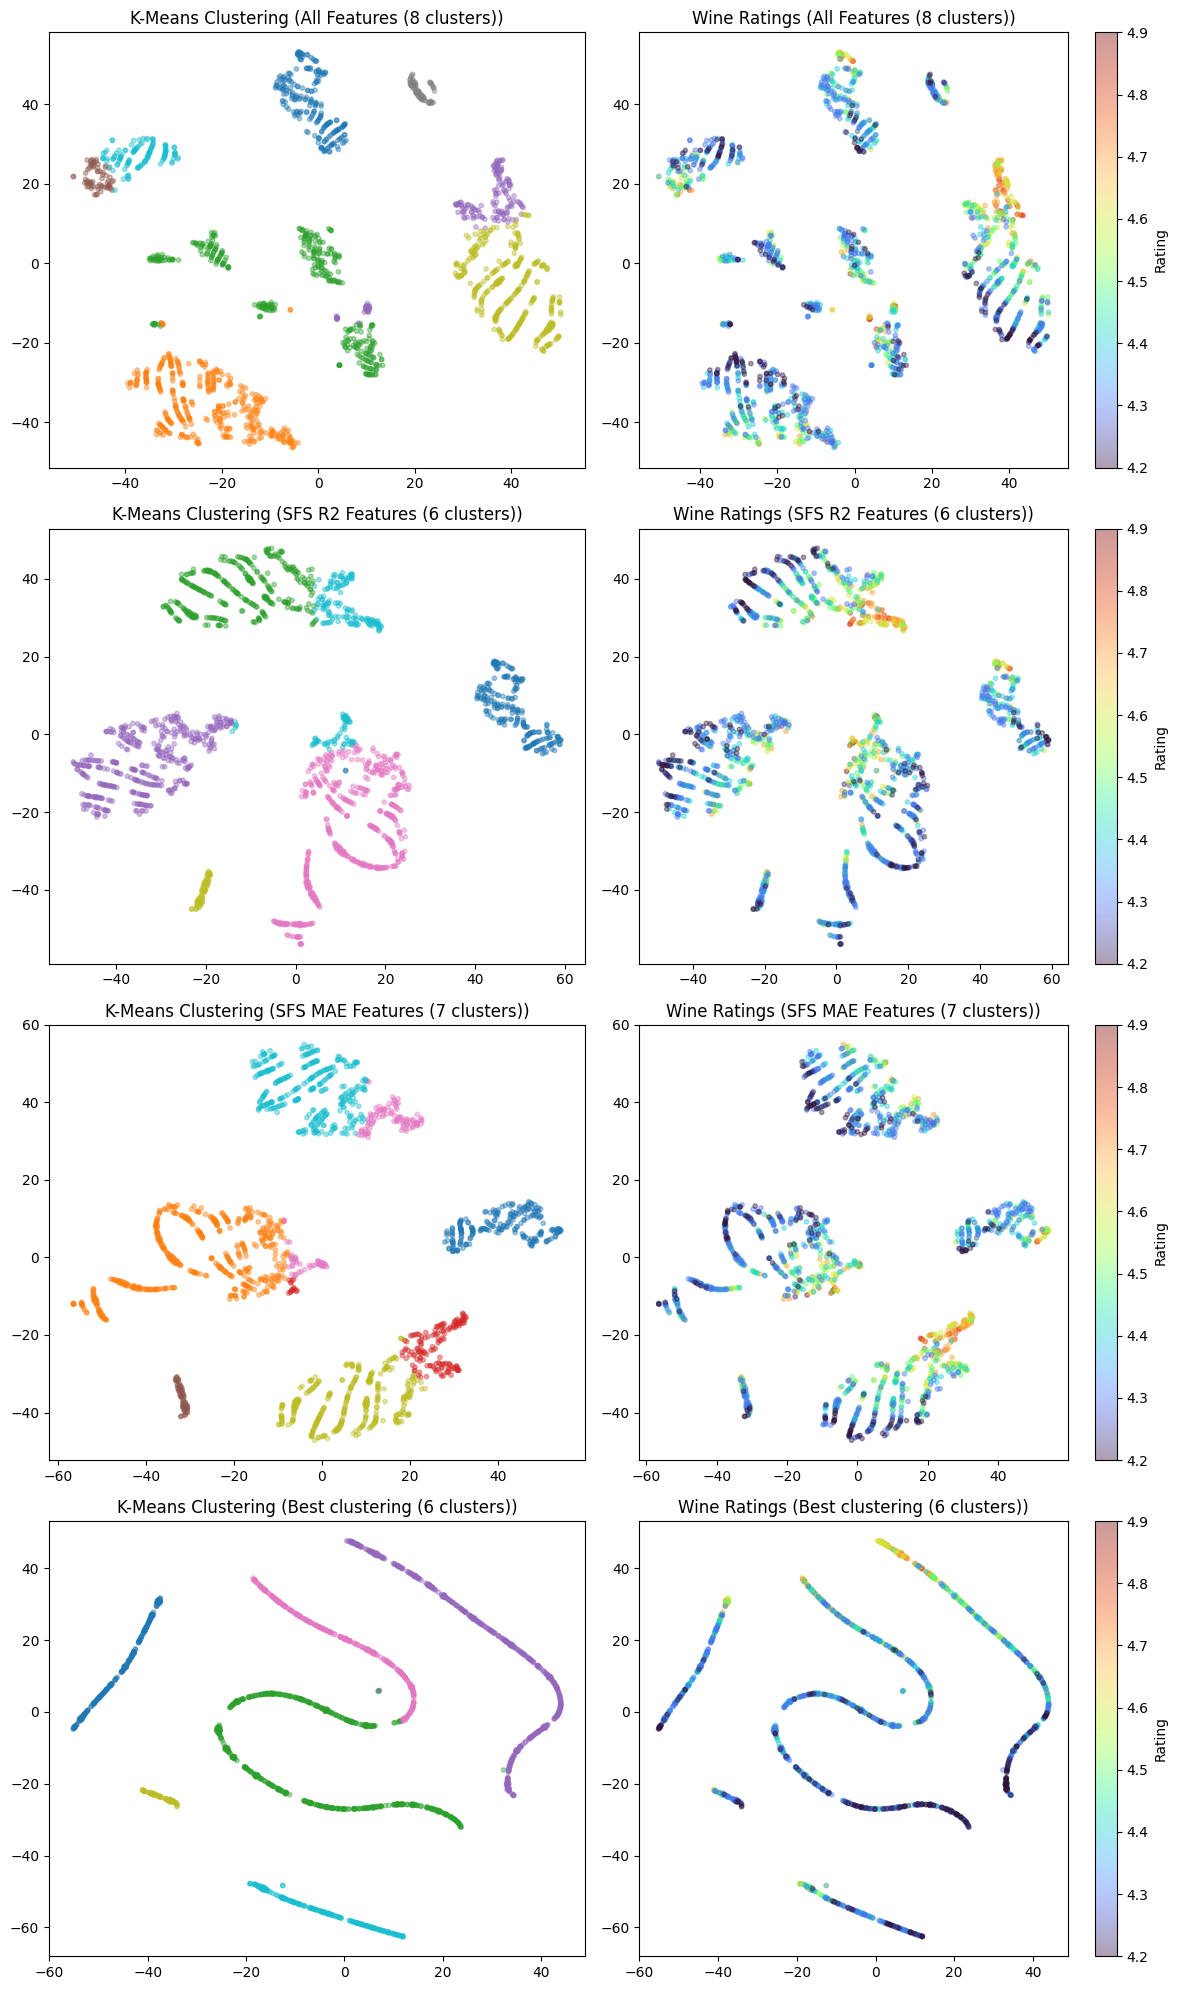

<Figure size 640x480 with 0 Axes>

In [ ]:
# Now I want to visualise the three best clustering results based on the silhouette scores above with t-SNE + one example for the "best clustering". 
# I want to see next to each other on the left the clustering labels and on the right another t-SNE visualisation, but colored with the wine ratings.
# I will use 8 clusters for the all features set, 7 clusters for the SFS R2 set and 6 clusters for the SFS MAE set and the best clustering set.

feature_sets = {
    'All Features (8 clusters)': (feature_columns_all, 8),
    'SFS R2 Features (6 clusters)': (feature_columns_sfs_r2, 6),
    'SFS MAE Features (7 clusters)': (feature_columns_sfs_mae, 7),
    'Best clustering (6 clusters)': (feature_columns_optimal_6_7_clusters, 6)
}
# Prepare the figure
fig, axes = plt.subplots(len(feature_sets), 2, figsize=(12, 5 * len(feature_sets)))
axes = axes.flatten()   
# Function to perform k-means clustering and plot the results
for i, (title, (features, n_clusters)) in enumerate(feature_sets.items()):
    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=1)
    labels = kmeans.fit_predict(X_scaled)
    
    # t-SNE for 2D visualization
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    
    # Plot clustering results
    axes[2*i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', s=10, alpha=0.4)
    axes[2*i].set_title(f'K-Means Clustering ({title})')
    
    # Plot wine ratings
    scatter = axes[2*i + 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['rating'], cmap='turbo', s=10, alpha=0.4)
    axes[2*i + 1].set_title(f'Wine Ratings ({title})')
    fig.colorbar(scatter, ax=axes[2*i + 1], label='Rating')
plt.tight_layout()
plt.show()
# Also add the same plots for hierarchical clustering with the same feature sets and number of clusters
for i, (title, (features, n_clusters)) in enumerate(feature_sets.items()):
    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(X_scaled)
    
    # t-SNE for 2D visualization
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    
    # Plot clustering results
    axes[2*i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', s=10, alpha=0.4)
    axes[2*i].set_title(f'Hierarchical Clustering ({title})')
    
    # Plot wine ratings
    scatter = axes[2*i + 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['rating'], cmap='turbo', s=10, alpha=0.4)
    axes[2*i + 1].set_title(f'Wine Ratings ({title})')
    fig.colorbar(scatter, ax=axes[2*i + 1], label='Rating')
plt.tight_layout()
plt.show()
                

**Observation**

I chose t-SNE for visualisation because in my tests it showed the groupings better than PCA. 

Interestingly, in each test there are clearly separated islands in the t-SNE plots, but they do not fully align with the new lables (left side plots.) 

I plotted the same t-SNE visualisation using ratings for colouring on the right hand side as I selected the features based on the rating models. What I see is that the clusters do not match the ratings, but within each island the ratings seem to trend in a certain direction. I wonder if I can interpret this as a consequence of the good regression of the selected features with rating: Closer points should also have closer ratings, even if rating is not a feature. 

Finally, the "best clustering" example at the bottom confirms what I think is a consequence of using mostly binary features: We see lines rather than point clusters. But notably here also I observe the rating trend within each cluster (even though "age_log" is not included!)

 

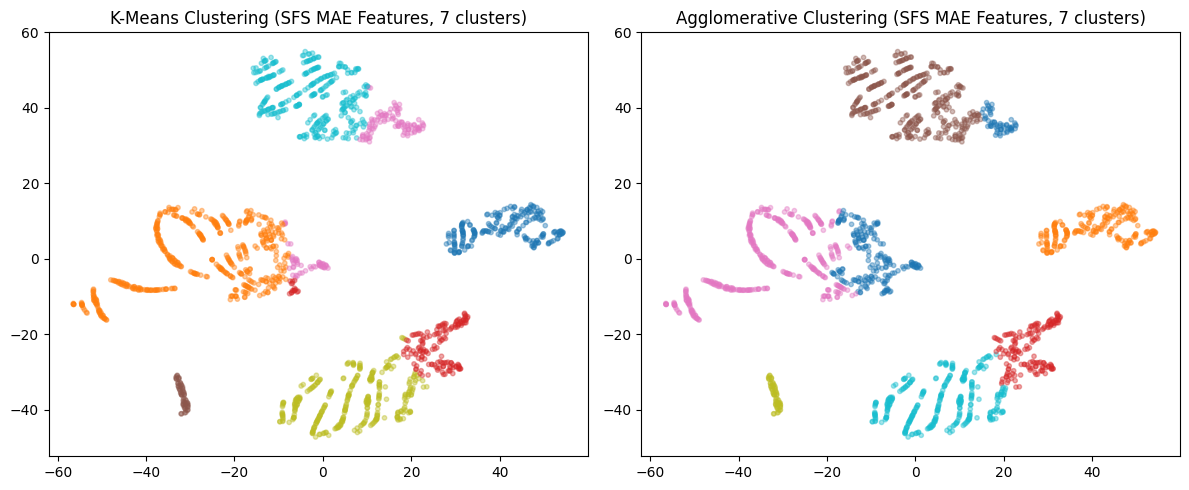

K-Means Silhouette Score: 0.5053281612614587
Agglomerative Silhouette Score: 0.4760311892672409


In [57]:
# Now I will plot the t-SNE visualitions for 6 SFS MAE features and 7 clusters for both agglomerative clustering and KMeans next to each other for comparison.
# Also add the silhouette scores for both methods.
X = df[feature_columns_sfs_mae]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=7, random_state=1)
kmeans_labels = kmeans.fit_predict(X_scaled)
model = AgglomerativeClustering(n_clusters=7)
agglo_labels = model.fit_predict(X_scaled)
# t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
# Prepare the figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Plot KMeans clustering results
axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='tab10', s=10, alpha=0.4) 
axes[0].set_title('K-Means Clustering (SFS MAE Features, 7 clusters)')
# Plot Agglomerative clustering results
axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=agglo_labels, cmap='tab10', s=10, alpha=0.4) 
axes[1].set_title('Agglomerative Clustering (SFS MAE Features, 7 clusters)')
plt.tight_layout()
plt.show()

# Calculate silhouette scores
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
agglo_silhouette = silhouette_score(X_scaled, agglo_labels)
print(f"K-Means Silhouette Score: {kmeans_silhouette}")
print(f"Agglomerative Silhouette Score: {agglo_silhouette}")





**Observations:**  

There are some differences in the clustering between KMeans and Agglomerative Clustering. However, by and large the clusters are similar in structure. As I do not know what these clusters mean, it is hard for me to decide which ones are better, except by going for the silhouette score, which is higher for K-Means. 

### 3. Cluster metrics/comparison table on the data + elbow plots


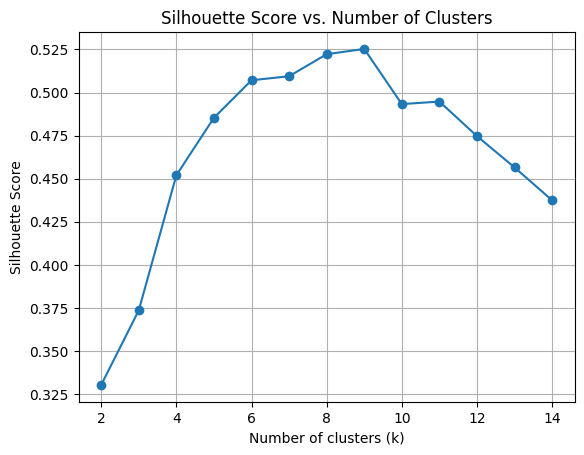

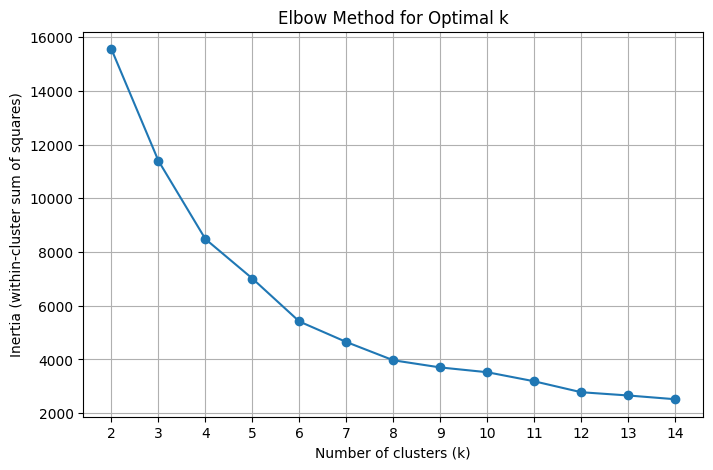

In [80]:
# ---- Your code here ----


sil_scores = []
sil_scores_agglom = []
inertias = []
ks = range(2, 15)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=1)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))
    inertias.append(kmeans.inertia_)

plt.plot(ks, sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.grid(True)
plt.show()

# Plotting the elbow
plt.figure(figsize=(8, 5))
plt.plot(ks, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.title('Elbow Method for Optimal k')
plt.xticks(ks)
plt.grid(True)
plt.show()



**Observations:**  

### 4. PCA (variance plot + PC scatter plot)


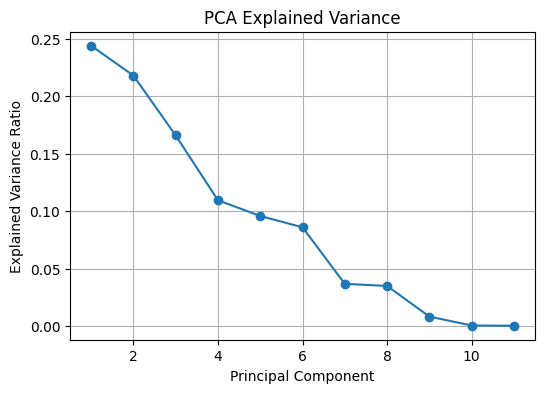

In [81]:
# ---- Your code here ----
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA
pca = PCA()
pca.fit(X_scaled)

# Plot explained variance ratio
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

**Observations:**  

### 5. Low-dimensional plot coloured by cluster or rating


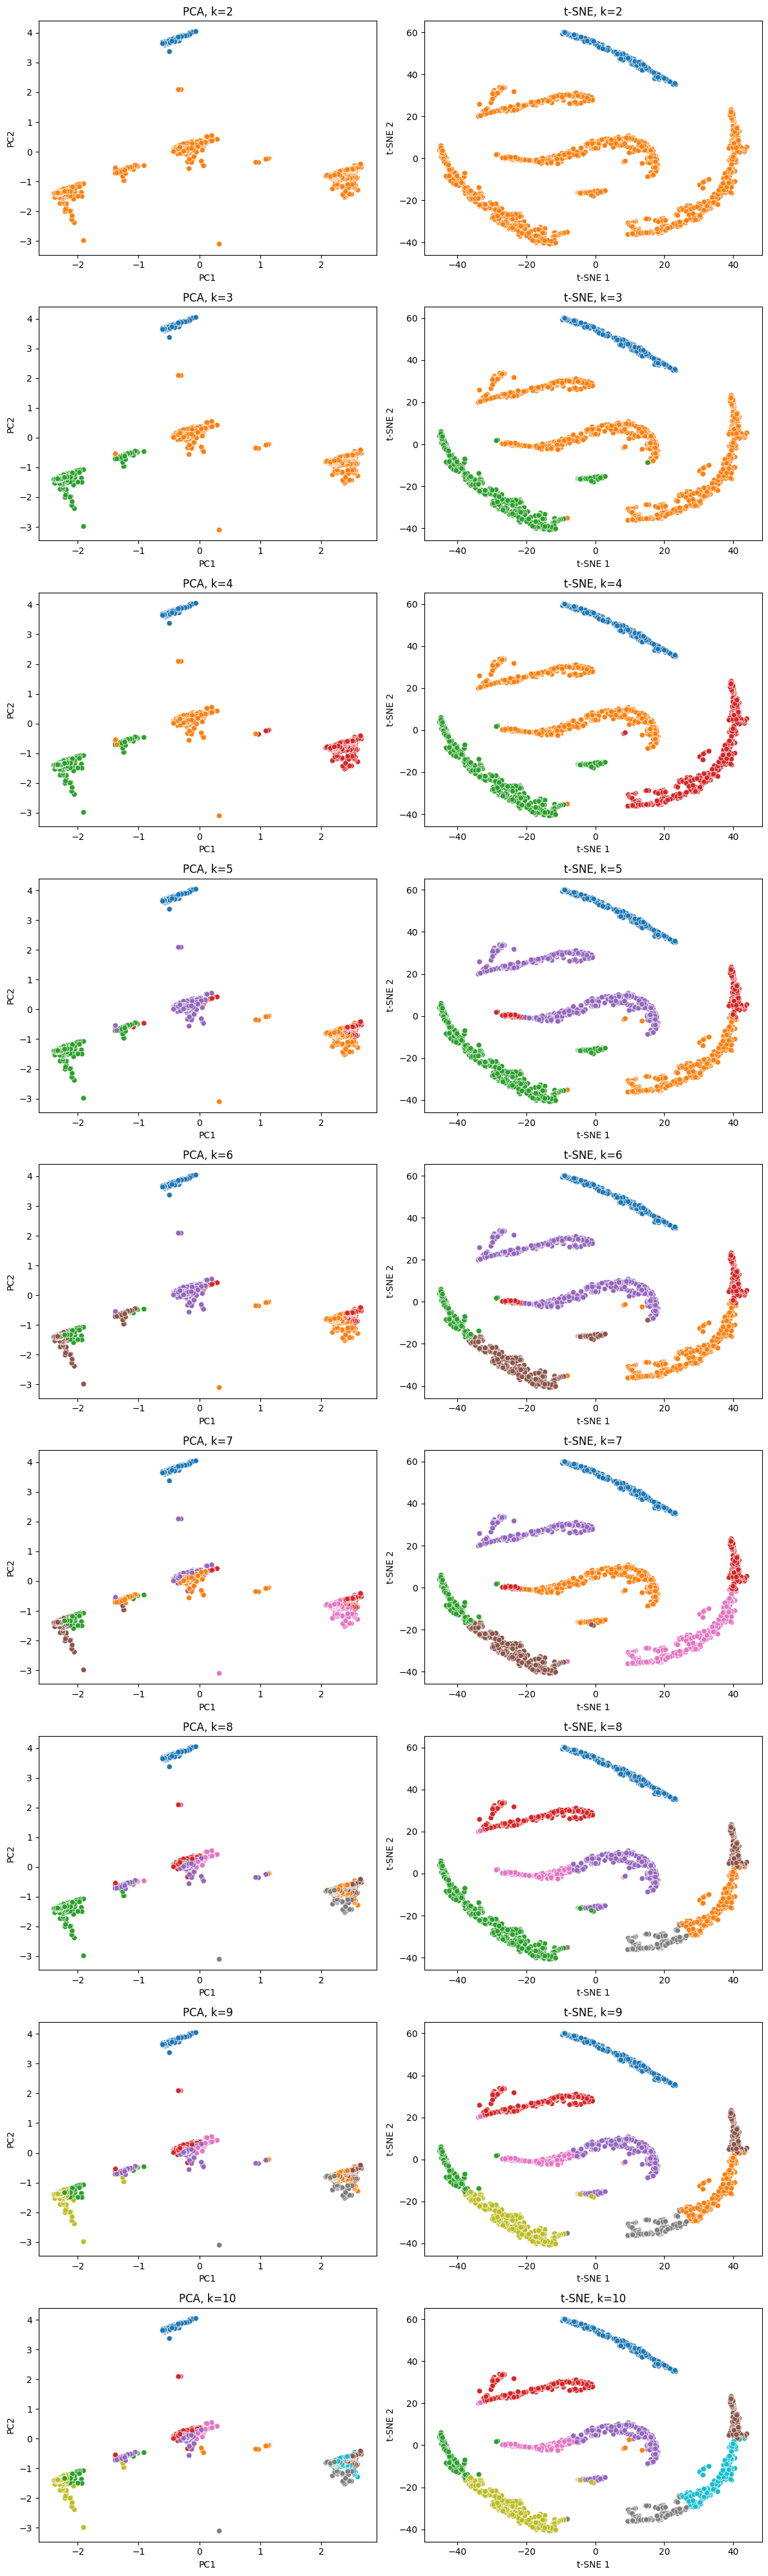

In [ ]:
# ---- Your code here ----
fig, axes = plt.subplots(nrows=9, ncols=2, figsize=(12, 40))
axes = axes.flatten()

# Reduce dimensions using PCA for visualization
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_scaled)

# Function to perform k-means clustering and plot the results
for i, n_clusters in enumerate(range(2, 11)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1)
    labels = kmeans.fit_predict(X_reduced)
    
    # Reduce dimensions using PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_reduced)

    # Reduce dimensions using t-SNE for visualization
    tsne = TSNE(n_components=2, init='pca', random_state=1)
    X_tsne = tsne.fit_transform(X_reduced)

    # Plot PCA on left column
    ax_pca = axes[2*i]
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='tab10', legend=False, ax=ax_pca)
    ax_pca.set_title(f'PCA, k={n_clusters}')
    ax_pca.set_xlabel('PC1')
    ax_pca.set_ylabel('PC2')
    
    # Plot t-SNE on right column
    ax_tsne = axes[2*i + 1]
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='tab10', legend=False, ax=ax_tsne)
    ax_tsne.set_title(f't-SNE, k={n_clusters}')
    ax_tsne.set_xlabel('t-SNE 1')
    ax_tsne.set_ylabel('t-SNE 2')
    


plt.tight_layout()
plt.show()


**Observations:**  

### 6. Supervised classifier trained + confusion matrix

In [ ]:
# ---- Your code here ----

**Observations:**  

### 7. Comparative discussion (unsupervised vs supervised)

In [ ]:
# ---- Your code here ----

**Observations:**  

### 7. Perform cross validation and statistical techniques (advanced)

In [ ]:
# ---- Your code here ----

**Observations:**  